# Proyek Klasifikasi Gambar: Shoe vs Sandal vs Boot Image Dataset (15K Images)
- **Nama:** Halim Sajidi
- **Email:** halimsajidi14@gmail.com
- **ID Dicoding:** halimsajidi

# Import Semua Packages/Library yang Digunakan

In [6]:
from google.colab import drive
import zipfile
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from skimage import io
import cv2
from skimage.transform import rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from skimage import img_as_ubyte
import numpy as np
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
from PIL import Image

# Data Preparation

## load images dataset

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Path ke dataset.zip di Google Drive
zip_path = '/content/drive/MyDrive/halim/dicoding/pengembangan machine learning/dataset.zip'

# Path untuk ekstraksi
extract_path = '/content/'

# Ekstrak file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Set the path to the dataset folder
dataset_path = os.path.join(extract_path, 'Shoe vs Sandal vs Boot Dataset')

# Listing the files in the dataset folder to ensure it's correctly extracted
print(os.listdir(dataset_path))

['Sandal', 'Shoe', 'Boot']


In [16]:
source_dirs = {
    "Boot": "/content/Shoe vs Sandal vs Boot Dataset/Boot",
    "Sandal": "/content/Shoe vs Sandal vs Boot Dataset/Sandal",
    "Shoe": "/content/Shoe vs Sandal vs Boot Dataset/Shoe"
}

target_root_dir = "/content/dataset"

res = [(100, 100), (400, 200), (150, 300)]

# Fungsi untuk mengubah resolusi gambar
def resize_images(source_dir, target_dir, res):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for root, dirs, files in os.walk(source_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    # Pilih resolusi secara acak
                    new_res = random.choice(res)
                    img_resized = img.resize(new_res)

                    # Simpan gambar yang telah diubah resolusinya
                    relative_path = os.path.relpath(root, source_dir)
                    target_path = os.path.join(target_dir, relative_path)

                    if not os.path.exists(target_path):
                        os.makedirs(target_path)

                    img_resized.save(os.path.join(target_path, file))

# Mengubah resolusi gambar untuk setiap kategori
for category, source_dir in source_dirs.items():
    target_dir = os.path.join(target_root_dir, category)
    resize_images(source_dir, target_dir, res)

## membuat dataset label

In [9]:
# Path ke direktori dataset
dataset_dir = '/content/dataset/'

# Daftar untuk menyimpan data
data = []

# Iterasi melalui setiap folder (Boot, Sandal, Shoe)
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)

    if os.path.isdir(label_dir):
        # Iterasi melalui setiap gambar dalam folder
        for filename in os.listdir(label_dir):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Ganti ekstensi jika perlu
                filepath = os.path.join(label_dir, filename)
                data.append({'filename': filename, 'filepath': filepath, 'label': label})

# Membuat DataFrame
dataset_df = pd.DataFrame(data)

In [22]:
# Fungsi untuk mendapatkan resolusi gambar
def get_image_resolution(filepath):
    try:
        with Image.open(filepath) as img:
            return img.size
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return (None, None)

# Menambahkan kolom resolusi ke dataset_df
dataset_df['resolution'] = dataset_df['filepath'].apply(get_image_resolution)
# dataset_df[['width', 'height']] = pd.DataFrame(dataset_df['resolution'].tolist(), index=dataset_df.index)

# # Menghapus kolom 'resolution' yang tidak diperlukan lagi
# dataset_df = dataset_df.drop(columns=['resolution'])

In [23]:
dataset_df

,filename,filepath,label,resolution
0,Sandal (4700).jpg,/content/dataset/Sandal/Sandal (4700).jpg,Sandal,"(400, 200)"
1,Sandal (3524).jpg,/content/dataset/Sandal/Sandal (3524).jpg,Sandal,"(150, 300)"
2,Sandal (3953).jpg,/content/dataset/Sandal/Sandal (3953).jpg,Sandal,"(400, 200)"
3,Sandal (4745).jpg,/content/dataset/Sandal/Sandal (4745).jpg,Sandal,"(400, 200)"
4,Sandal (2510).jpg,/content/dataset/Sandal/Sandal (2510).jpg,Sandal,"(100, 100)"
...,...,...,...,...
14995,boot (2077).jpg,/content/dataset/Boot/boot (2077).jpg,Boot,"(400, 200)"
14996,boot (4453).jpg,/content/dataset/Boot/boot (4453).jpg,Boot,"(400, 200)"
14997,boot (1046).jpg,/content/dataset/Boot/boot (1046).jpg,Boot,"(100, 100)"
14998,boot (1137).jpg,/content/dataset/Boot/boot (1137).jpg,Boot,"(400, 200)"


In [19]:
dataset_df['label'].value_counts()

label
Sandal    5000
Shoe      5000
Boot      5000
Name: count, dtype: int64

## Data checking

<Axes: >

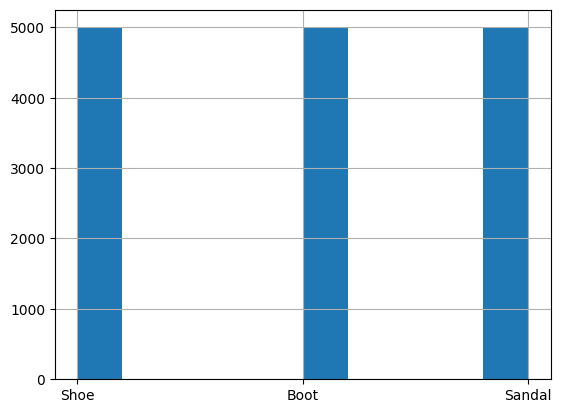

In [ ]:
# membuat histogram untuk semua kategori pada class variable
dataset_df['label'].hist()

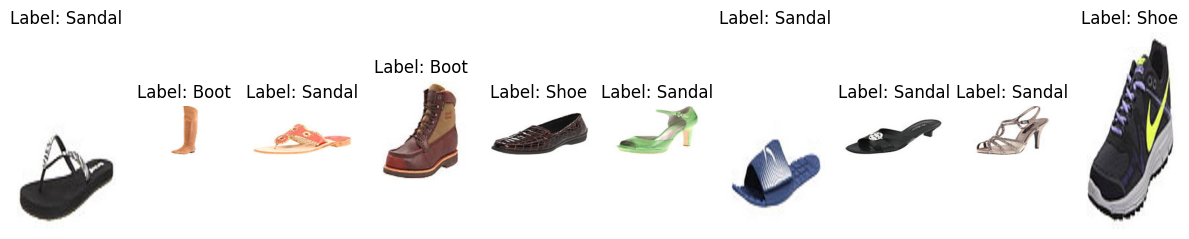

In [ ]:
# Pilih hanya 9 gambar pertama (atau pilih subset lainnya jika diperlukan)
df_sample = dataset_df.sample(frac=1).reset_index(drop=True).head(10)

# Menampilkan gambar dan label
def display_images_with_labels(df):
    num_images = len(df)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    if num_images == 1:
        axes = [axes]  # Jika hanya satu gambar, axes tidak dalam bentuk list

    for ax, (idx, row) in zip(axes, df.iterrows()):
        img = mpimg.imread(row['filepath'])
        ax.imshow(img)
        ax.set_title(f'Label: {row["label"]}')
        ax.axis('off')  # Menghilangkan axis

    plt.show()

# Panggil fungsi untuk menampilkan gambar
display_images_with_labels(df_sample)

# Modelling

In [ ]:
# menggunakan GPU untuk mengefisienkan waktu training model
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
class callback_model(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>0.95):
            print("\n\nTarget tercapai\n")
            self.model.stop_training = True

def alaskaki():

    TRAINING_DIR = "/content/Shoe vs Sandal vs Boot Dataset/"
    training_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        zoom_range=0.2,
        shear_range=0.2,
        rotation_range=20,
        validation_split=0.2) # Dataset dibagi menjadi 80% train 20% validasi

    train_generator = training_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(150,150),
        color_mode='rgb',
        class_mode='categorical',
        subset='training')

    validation_datagen = ImageDataGenerator(rescale=1./255)
    validation_generator= training_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(150,150),
        color_mode='rgb',
        class_mode='categorical',
        subset='validation')

    model = tf.keras.models.Sequential([
        #layer1
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(),
        #layer2
        tf.keras.layers.Conv2D(64, (4, 4), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        #layer3
        tf.keras.layers.Conv2D(128, (7, 7), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        #layer4
        tf.keras.layers.Conv2D(128, (8, 8), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        #Flatten
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        #Dense layer1
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        #Dense layer2
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        #output layer
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    callback = callback_model()

    model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
    history = model.fit(
        train_generator,
        epochs=1000,
        steps_per_epoch=20,
        validation_data=validation_generator,
        callbacks=callback,
        verbose=1,
        validation_steps=3)
    return model, history

In [ ]:
model, history = alaskaki()

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Epoch 1/1000
20/20 [==============================] - 14s 266ms/step - loss: 3.4477 - accuracy: 0.4688 - val_loss: 2.1499 - val_accuracy: 0.2917
Epoch 2/1000
20/20 [==============================] - 5s 249ms/step - loss: 1.8522 - accuracy: 0.5219 - val_loss: 1.5703 - val_accuracy: 0.3958
Epoch 3/1000
20/20 [==============================] - 5s 262ms/step - loss: 1.4695 - accuracy: 0.5625 - val_loss: 3.1824 - val_accuracy: 0.3646
Epoch 4/1000
20/20 [==============================] - 7s 353ms/step - loss: 1.3650 - accuracy: 0.5656 - val_loss: 0.9235 - val_accuracy: 0.6354
Epoch 5/1000
20/20 [==============================] - 6s 312ms/step - loss: 1.2118 - accuracy: 0.5578 - val_loss: 0.8572 - val_accuracy: 0.6771
Epoch 6/1000
20/20 [==============================] - 5s 247ms/step - loss: 1.0169 - accuracy: 0.6266 - val_loss: 0.7346 - val_accuracy: 0.6875
Epoch 7/1000
20/20 [==============================

## Evaluasi dan Visualisasi

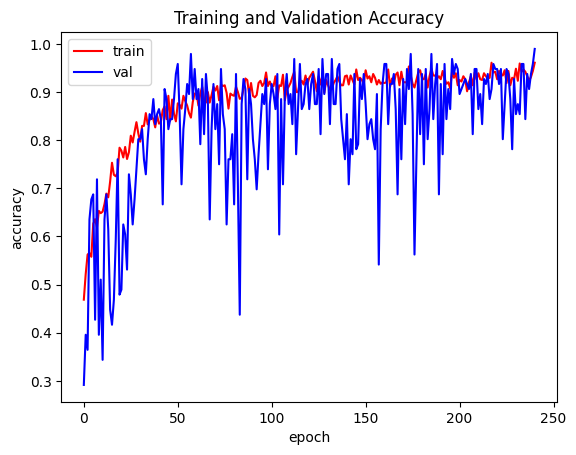

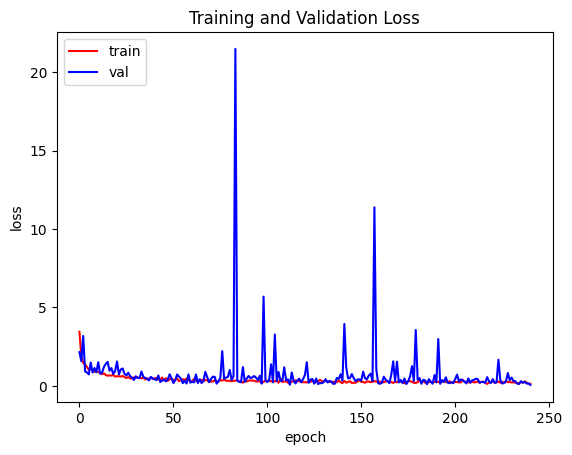

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

# Konversi Model

## save model

In [ ]:
model.save('/content/saved_model')

In [ ]:
# Compress the folder
shutil.make_archive('/content/saved_model', 'zip', '/content/saved_model')

# Download the compressed file
files.download('/content/saved_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Tensorflow.js

In [ ]:
pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 27.2 MB/s eta 0

In [ ]:
# Convert the model to TensorFlow.js format
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /content/saved_model/ \
    /content/model

2024-07-29 10:27:35.817314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 10:27:35.845210: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 10:27:35.845275: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 10:27:37.105135: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-29 10:27:39.345701: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [ ]:
# Compress the folder
shutil.make_archive('/content/model', 'zip', '/content/model')

# Download the compressed file
files.download('/content/model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Tensoflow lite

In [ ]:
# Load the TensorFlow SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model')
tflite_model = converter.convert()

# Save the converted model to a file
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
class_labels = ["Boot", "Sandal", "Shoe"]

with open('/content/label.txt', 'w') as f:
    for label in class_labels:
        f.write(f"{label}\n")


# Inference (Optional)

In [ ]:
from google.colab import files
import io

Saving download.jfif to download.jfif


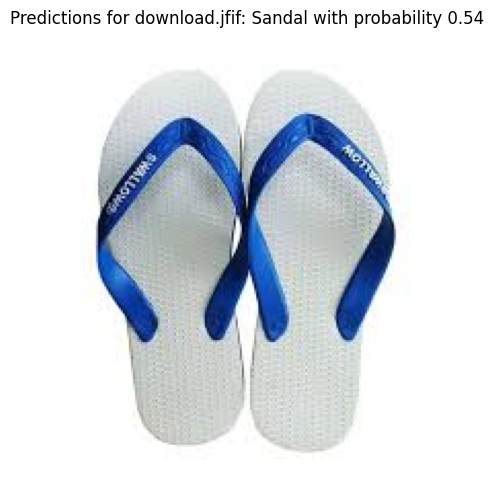

In [ ]:
# Upload the new image data
uploaded = files.upload()

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path='/content/model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess image
def preprocess_image(image, target_size):
    image = image.resize(target_size)
    image = np.array(image).astype('float32')  # Convert to float32
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Read the class labels
with open('/content/label.txt', 'r') as f:
    class_labels = f.read().splitlines()

# Model's input size is (150, 150)
target_size = (150, 150)

# Make predictions
for filename in uploaded.keys():
    image = Image.open(io.BytesIO(uploaded[filename]))
    preprocessed_image = preprocess_image(image, target_size)

    # Set the tensor to point to the input data
    interpreter.set_tensor(input_details[0]['index'], preprocessed_image)

    # Run the interpreter
    interpreter.invoke()

    # Get the predictions
    predictions = interpreter.get_tensor(output_details[0]['index'])
    predicted_class_index = np.argmax(predictions)
    predicted_class_label = class_labels[predicted_class_index]

    # Display the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Predictions for {filename}: {predicted_class_label} with probability {predictions[0][predicted_class_index]:.2f}")
    plt.axis('off')
    plt.show()

In [ ]:
pip freeze > requirements.txt